<a href="https://colab.research.google.com/github/07codeninja/-Accredian-Backend-task/blob/main/IDC_cancer%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from timm import create_model
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from PIL import Image

In [ ]:
import torch
device = torch.device("cpu")
print("Using CPU for training. It will be slow but will work.")


# Paths
DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"  # Folder containing 'IDC' and 'normal' subfolders
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
IMG_SIZE = 256
NUM_CLASSES = 2  # IDC vs Normal


Using CPU for training. It will be slow but will work.


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load full dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

# Split dataset (80% Train, 10% Val, 10% Test)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Check dataset split
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 960, Val: 120, Test: 120


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load EfficientNet-B0 with pretrained weights
model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
model.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from timm import create_model
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Paths and params
DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"
BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = 2
EPOCHS = 15
LR = 0.0005

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Load model
model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ========================
# STAGE 2: TRAINING FUNCTION
# ========================
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Validation Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/CAPSTONE/best_model.pth")
            print("Best model saved!")

Using cpu


In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, EPOCHS)

Epoch [1/15] - Loss: 1.9253, Train Acc: 0.7406
Validation Acc: 0.8417
Best model saved!
Epoch [2/15] - Loss: 1.0016, Train Acc: 0.8333
Validation Acc: 0.9167
Best model saved!
Epoch [3/15] - Loss: 0.9667, Train Acc: 0.8271
Validation Acc: 0.8583
Epoch [4/15] - Loss: 0.5746, Train Acc: 0.8604
Validation Acc: 0.8917
Epoch [5/15] - Loss: 0.4055, Train Acc: 0.8781
Validation Acc: 0.8667
Epoch [6/15] - Loss: 0.2747, Train Acc: 0.9031
Validation Acc: 0.9083
Epoch [7/15] - Loss: 0.2883, Train Acc: 0.9000
Validation Acc: 0.9333
Best model saved!
Epoch [8/15] - Loss: 0.2051, Train Acc: 0.9323
Validation Acc: 0.9250
Epoch [9/15] - Loss: 0.1522, Train Acc: 0.9458
Validation Acc: 0.9083
Epoch [10/15] - Loss: 0.1591, Train Acc: 0.9385
Validation Acc: 0.8917
Epoch [11/15] - Loss: 0.1405, Train Acc: 0.9563
Validation Acc: 0.9333
Epoch [12/15] - Loss: 0.1997, Train Acc: 0.9479
Validation Acc: 0.9250
Epoch [13/15] - Loss: 0.1725, Train Acc: 0.9417
Validation Acc: 0.9167
Epoch [14/15] - Loss: 0.1351, Tr

In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    best_acc = 0.0

    # Track metrics
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

                val_loss += loss.item()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/CAPSTONE/best_model.pth")
            print("✅ Best model saved!")

    # Save plots
    os.makedirs("/content/drive/MyDrive/CAPSTONE/metrics", exist_ok=True)

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label="Train Accuracy")
    plt.plot(val_acc_list, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.savefig("/content/drive/MyDrive/CAPSTONE/metrics/accuracy_curve.png")
    plt.show()

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label="Train Loss")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.savefig("/content/drive/MyDrive/CAPSTONE/metrics/loss_curve.png")
    plt.show()


In [ ]:
import os


In [ ]:
os.makedirs("/content/drive/MyDrive/CAPSTONE/metrics", exist_ok=True)


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from timm import create_model
import os
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)


DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"
SAVE_DIR = "/content/drive/MyDrive/CAPSTONE"
METRIC_DIR = os.path.join(SAVE_DIR, "metrics")

BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = 2
EPOCHS = 30
LR = 0.0005


os.makedirs(METRIC_DIR, exist_ok=True)


train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


        model.eval()
        val_correct, val_total = 0, 0
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_running_loss += loss.item()

        val_acc = val_correct / len(val_loader.dataset)
        val_loss = val_running_loss / len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Validation Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model.pth"))
            print("✅ Best model saved!")


    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(METRIC_DIR, "accuracy_curve.png"))
    plt.close()


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(METRIC_DIR, "loss_curve.png"))
    plt.close()


train(model, train_loader, val_loader, optimizer, criterion, EPOCHS)


Using cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/30] - Loss: 1.7011, Train Acc: 0.7635
Validation Acc: 0.7500
✅ Best model saved!
Epoch [2/30] - Loss: 1.2627, Train Acc: 0.8052
Validation Acc: 0.8583
✅ Best model saved!
Epoch [3/30] - Loss: 0.6943, Train Acc: 0.8427
Validation Acc: 0.7833
Epoch [4/30] - Loss: 0.9322, Train Acc: 0.8167
Validation Acc: 0.9000
✅ Best model saved!
Epoch [5/30] - Loss: 0.3769, Train Acc: 0.8927
Validation Acc: 0.9250
✅ Best model saved!
Epoch [6/30] - Loss: 0.4407, Train Acc: 0.8771
Validation Acc: 0.8750
Epoch [7/30] - Loss: 0.4176, Train Acc: 0.8833
Validation Acc: 0.8833
Epoch [8/30] - Loss: 0.2931, Train Acc: 0.8969
Validation Acc: 0.9250
Epoch [9/30] - Loss: 0.2026, Train Acc: 0.9302
Validation Acc: 0.9250
Epoch [10/30] - Loss: 0.2341, Train Acc: 0.9250
Validation Acc: 0.8833
Epoch [11/30] - Loss: 0.2040, Train Acc: 0.9323
Validation Acc: 0.9333
✅ Best model saved!
Epoch [12/30] - Loss: 0.1199, Train Acc: 0.9583
Validation Acc: 0.9333
Epoch [13/30] - Loss: 0.1670, Train Acc: 0.9323
Validatio

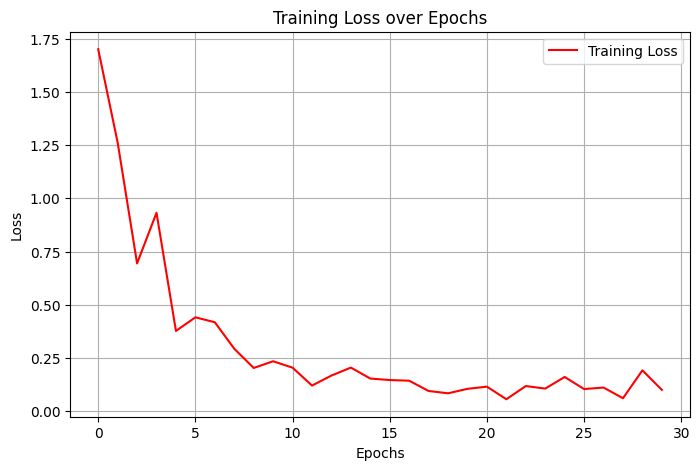

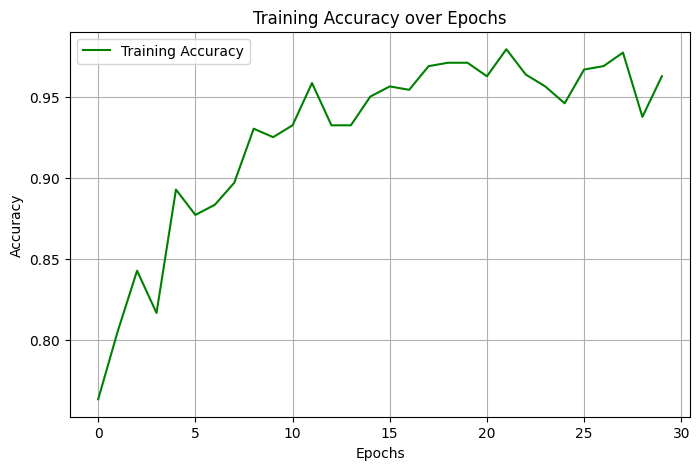

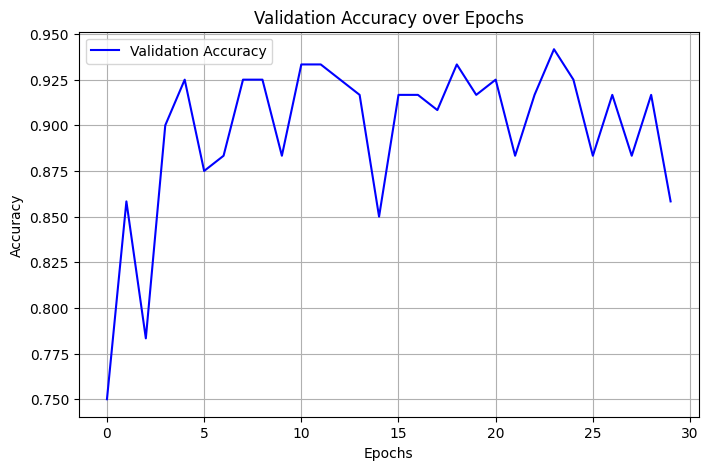

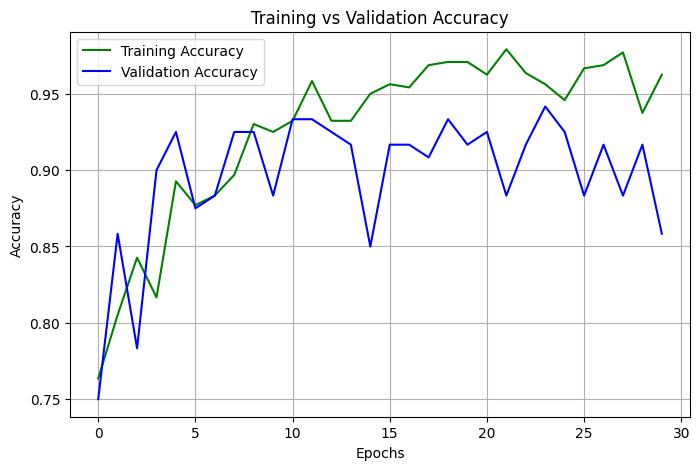

In [ ]:
import matplotlib.pyplot as plt
import os


metrics_dir = "/content/drive/MyDrive/CAPSTONE/metrics"
os.makedirs(metrics_dir, exist_ok=True)


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='red')
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "training_loss.png"))
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "training_accuracy.png"))
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "validation_accuracy.png"))
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "train_val_accuracy_comparison.png"))
plt.show()


Test Accuracy: 0.9417


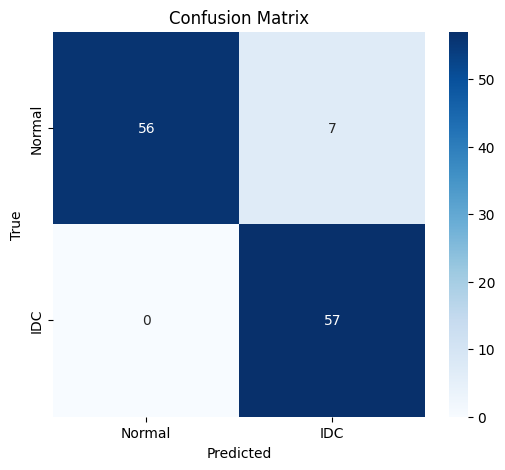

              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94        63
         IDC       0.89      1.00      0.94        57

    accuracy                           0.94       120
   macro avg       0.95      0.94      0.94       120
weighted avg       0.95      0.94      0.94       120



In [ ]:




import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import os


os.makedirs("/content/drive/MyDrive/CAPSTONE/metrics", exist_ok=True)


model.load_state_dict(torch.load("/content/drive/MyDrive/CAPSTONE/best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'IDC'], yticklabels=['Normal', 'IDC'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("/content/drive/MyDrive/CAPSTONE/metrics/confusion_matrix.png")
plt.show()


report = classification_report(all_labels, all_preds, target_names=['Normal', 'IDC'])
print(report)

with open("/content/drive/MyDrive/CAPSTONE/metrics/classification_report.txt", "w") as f:
    f.write(report)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import torch.nn.functional as F
import os


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        self.hook_handles.append(
            target_layer.register_forward_hook(self.save_activation)
        )
        self.hook_handles.append(
            target_layer.register_backward_hook(self.save_gradient)
        )

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

    def close(self):
        for handle in self.hook_handles:
            handle.remove()


def visualize_gradcam(model, img_path, transform, target_layer, save_path):
    model.eval()
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam(input_tensor)
    grad_cam.close()


    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    cv2.imwrite(save_path, superimposed_img)


gradcam_dir = "/content/drive/MyDrive/CAPSTONE/gradcam"
os.makedirs(gradcam_dir, exist_ok=True)


model.load_state_dict(torch.load("/content/drive/MyDrive/CAPSTONE/best_model.pth", map_location=device))
model.eval()


sample_loader = DataLoader(test_ds, batch_size=1, shuffle=True)
num_images_to_process = 10
processed = 0

for i, (img, label) in enumerate(sample_loader):
    if processed >= num_images_to_process:
        break

    img_path = test_ds.dataset.imgs[test_ds.indices[i]][0]
    try:
        visualize_gradcam(
            model,
            img_path,
            val_transform,
            target_layer=model.blocks[-1],
            save_path=os.path.join(gradcam_dir, f"gradcam_{i}.png")
        )
        print(f"Saved Grad-CAM for image {i}")
        processed += 1
    except Exception as e:
        print(f"Error processing image {i}: {e}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved Grad-CAM for image 0
Saved Grad-CAM for image 1
Saved Grad-CAM for image 2
Saved Grad-CAM for image 3
Saved Grad-CAM for image 4
Saved Grad-CAM for image 5
Saved Grad-CAM for image 6
Saved Grad-CAM for image 7
Saved Grad-CAM for image 8
Saved Grad-CAM for image 9


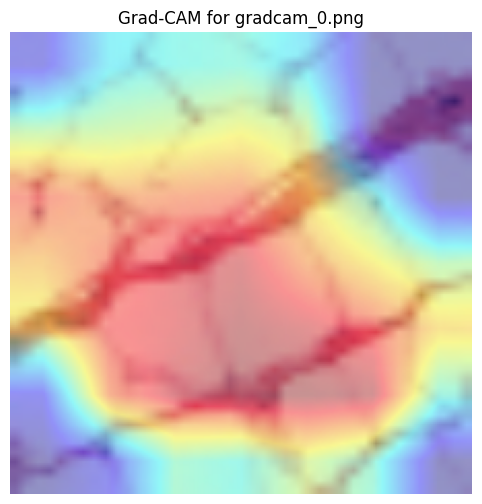

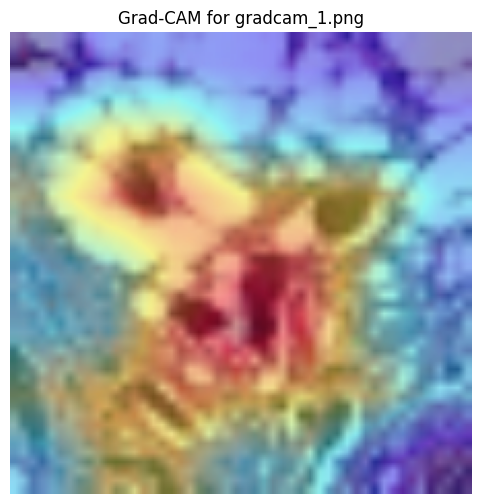

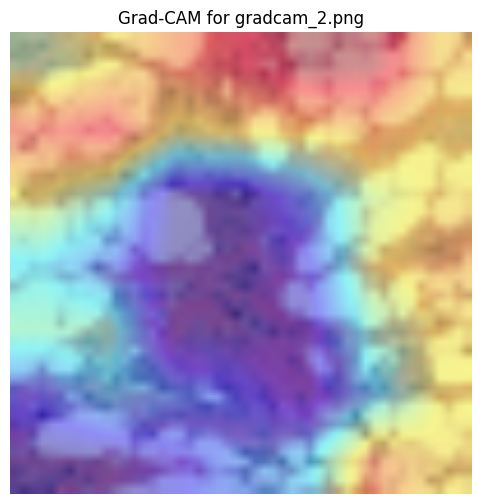

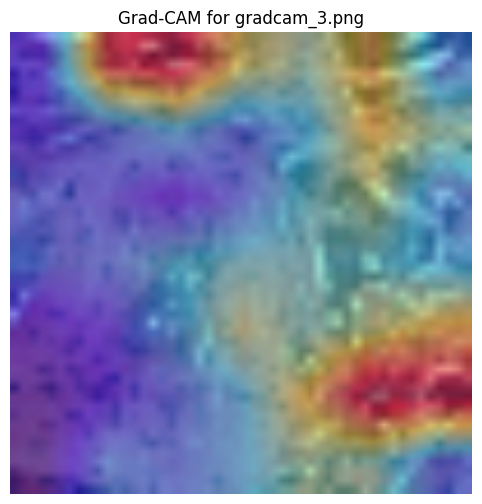

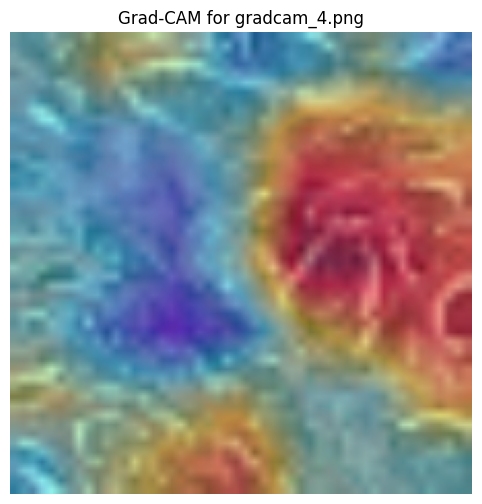

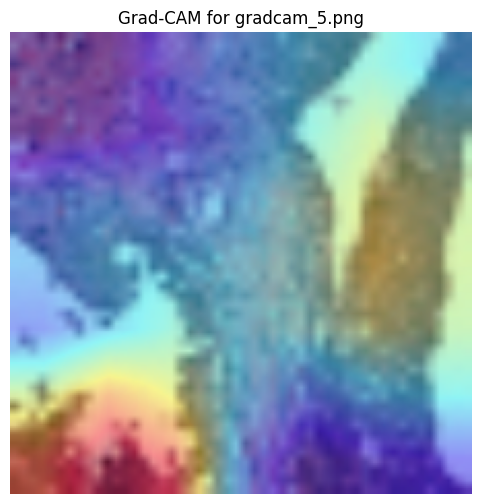

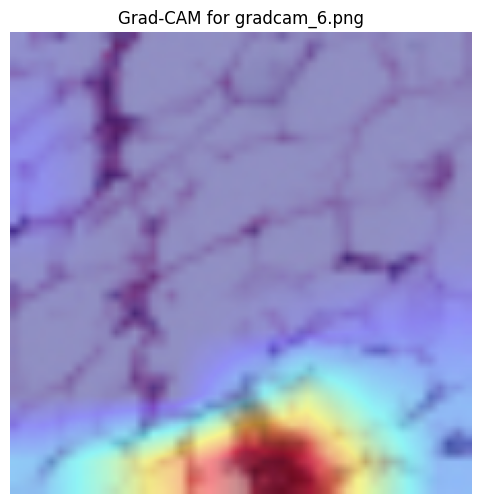

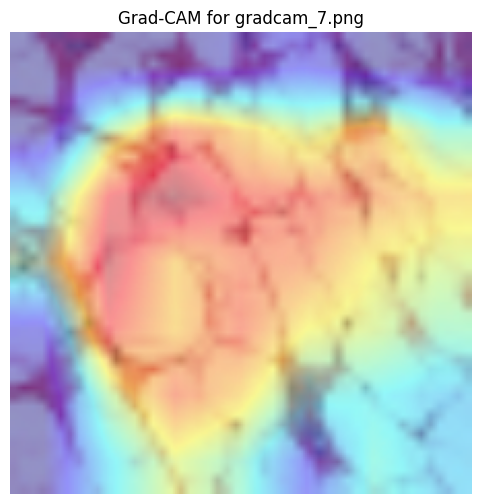

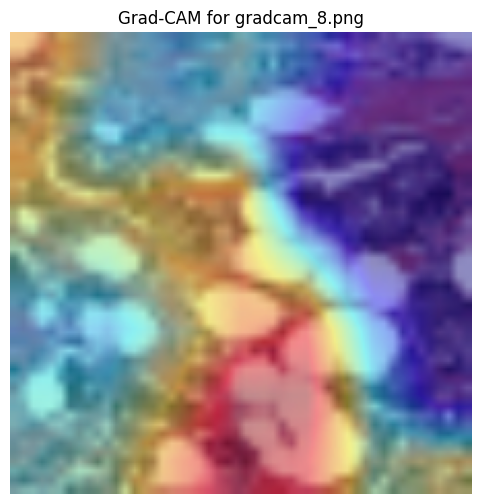

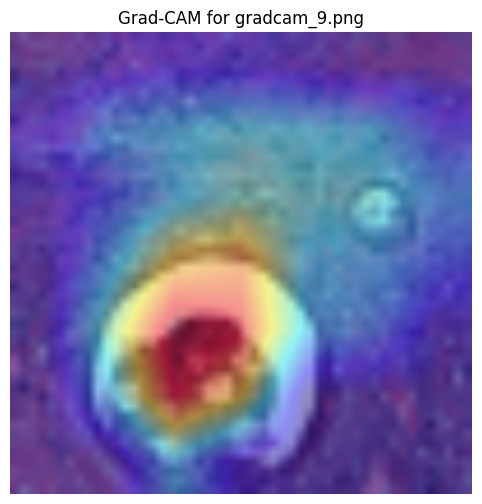

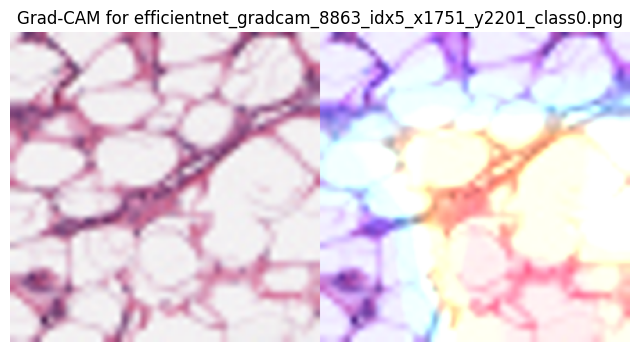

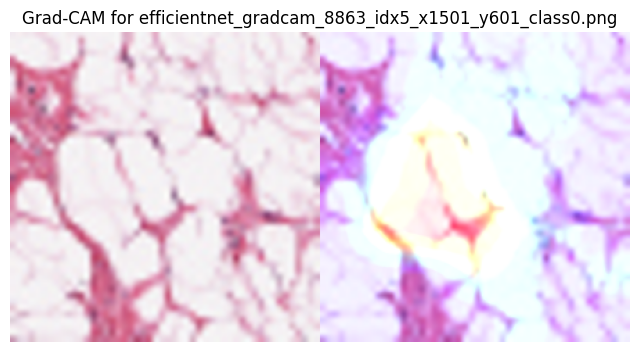

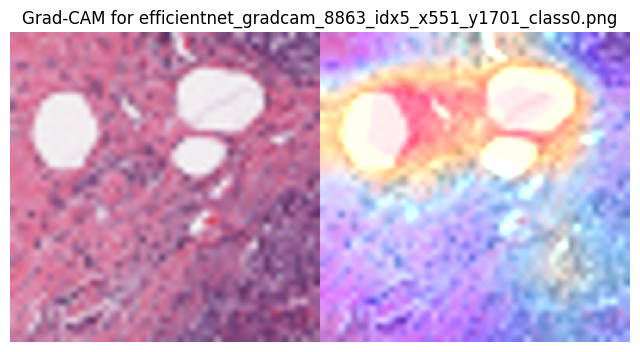

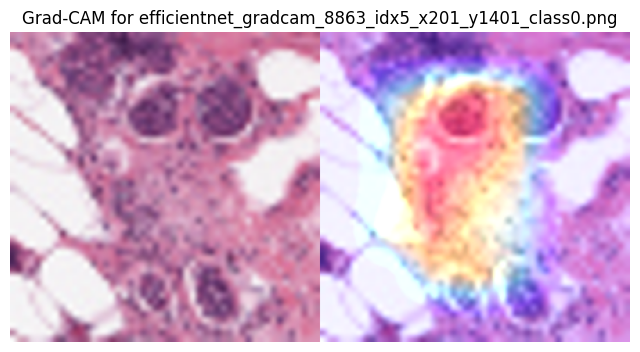

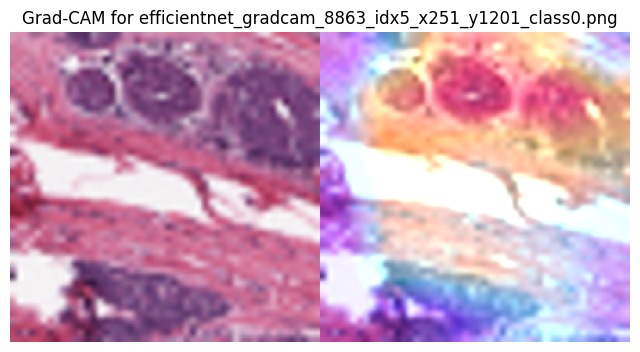

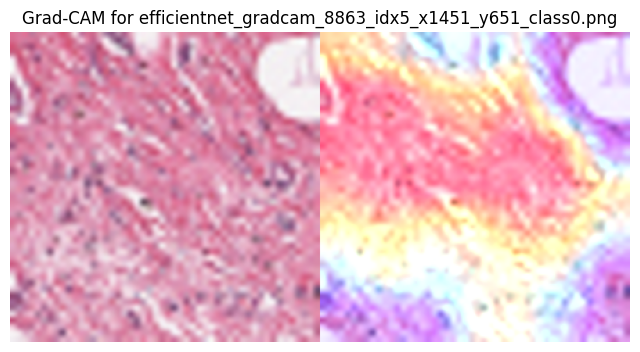

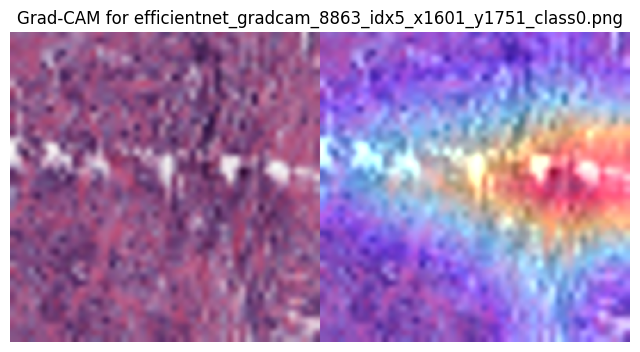

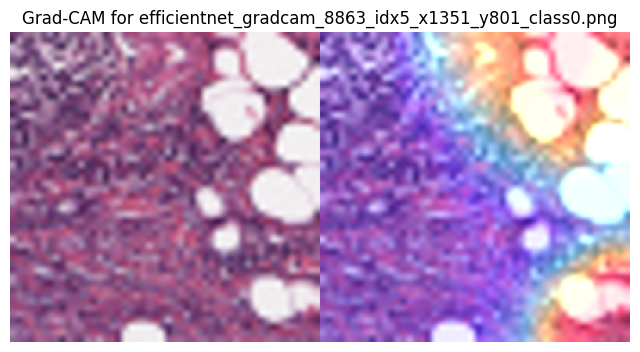

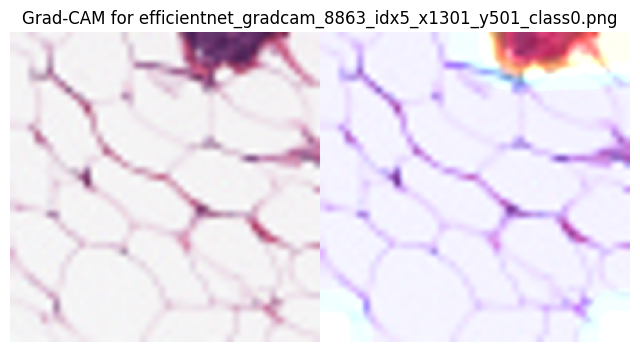

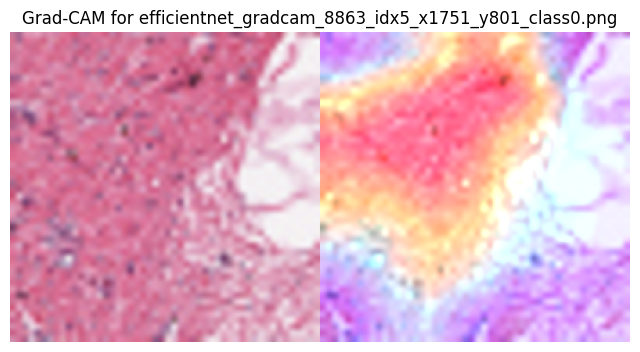

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os


gradcam_dir = "/content/drive/MyDrive/CAPSTONE/gradcam"


gradcam_images = [f for f in os.listdir(gradcam_dir) if f.endswith('.png')]


for img_name in gradcam_images:
    img_path = os.path.join(gradcam_dir, img_name)


    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Grad-CAM for {img_name}")
    plt.show()


In [ ]:

y_true = []
y_pred = []
y_probs = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)

        # Get predicted class labels
        _, preds = torch.max(outputs, 1)

        # Collect true labels, predicted labels, and probabilities for ROC and Precision-Recall
        y_true.extend(labels.cpu().numpy())  # True labels
        y_pred.extend(preds.cpu().numpy())   # Predicted labels
        y_probs.extend(outputs[:, 1].cpu().numpy())  # Probability for class 1 (IDC Cancer)

# Convert lists to numpy arrays for easier handling
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)


In [ ]:
from sklearn.metrics import classification_report

# Create a classification report and save to a text file
report = classification_report(y_true, y_pred, target_names=['Normal (0)', 'IDC Cancer (1)'])
print("Classification Report:\n", report)

with open(os.path.join(metrics_dir, "classification_report.txt"), "w") as f:
    f.write("Classification Report:\n\n")
    f.write(report)


Classification Report:
                 precision    recall  f1-score   support

    Normal (0)       0.98      0.83      0.90        63
IDC Cancer (1)       0.84      0.98      0.90        57

      accuracy                           0.90       120
     macro avg       0.91      0.90      0.90       120
  weighted avg       0.91      0.90      0.90       120



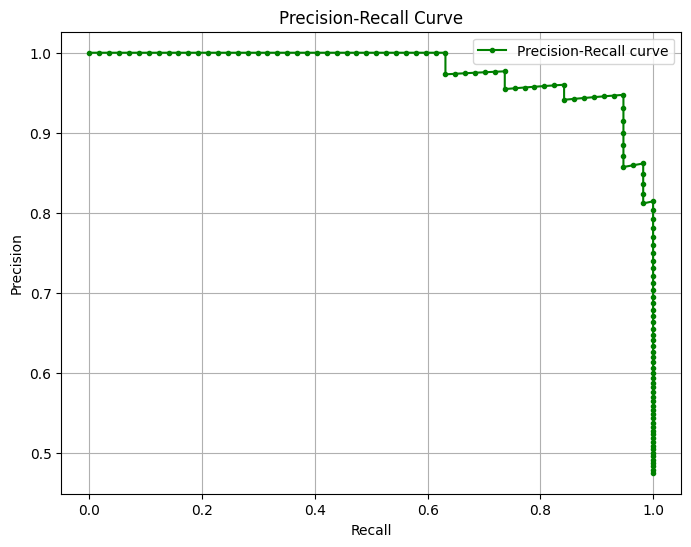

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(metrics_dir, "precision_recall_curve.png"))
plt.show()


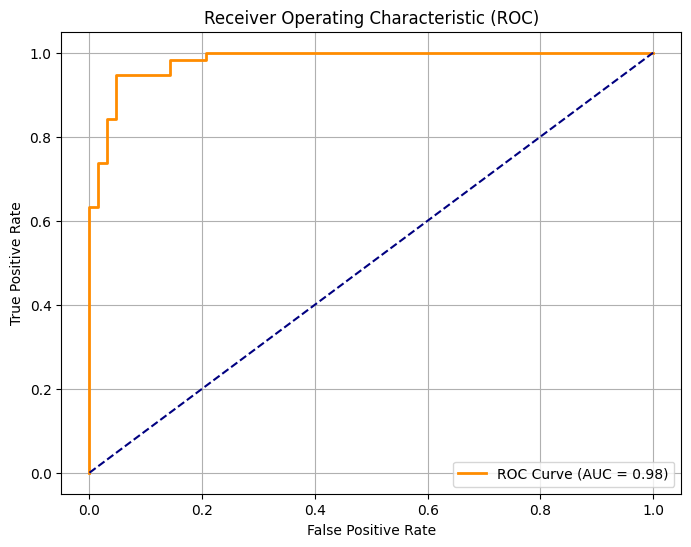

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "roc_curve.png"))
plt.show()


In [ ]:
# Create models directory if it doesn't exist
os.makedirs("/content/drive/MyDrive/CAPSTONE/models", exist_ok=True)

# Save the best model
torch.save(model.state_dict(), "/content/drive/MyDrive/CAPSTONE/models/efficientnet_best_model.pth")


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CAPSTONE/models/efficientnet_best_model.pth"))


<All keys matched successfully>

In [ ]:
# Create directory if it doesn't exist
os.makedirs("/content/drive/MyDrive/CAPSTONE/models", exist_ok=True)

# Save best VGG model
torch.save(model.state_dict(), "/content/drive/MyDrive/CAPSTONE/models/vgg_best_model.pth")


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CAPSTONE/models/vgg_best_model.pth"))


<All keys matched successfully>

In [ ]:
# config.py
import os
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"
SAVE_DIR = "/content/drive/MyDrive/CAPSTONE"
METRIC_DIR = os.path.join(SAVE_DIR, "metrics")
GRADCAM_DIR = os.path.join(SAVE_DIR, "gradcam")

# Create directories if not exist
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(METRIC_DIR, exist_ok=True)
os.makedirs(GRADCAM_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = 2
EPOCHS = 30
LR = 0.0005

# Labels
CLASS_NAMES = ['Normal', 'IDC']


Using device: cpu


In [ ]:
#Data Preparation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
#Model Setup
model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

✅ Found existing model. Skipping training...

📊 Test Accuracy: 0.9750

📋 Actual vs Predicted:
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actu

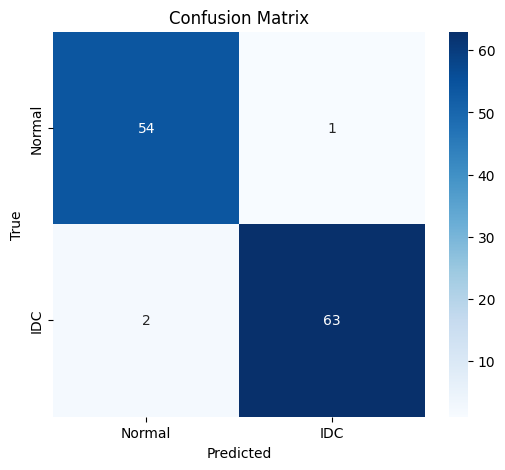


📈 Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.98      0.97        55
         IDC       0.98      0.97      0.98        65

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



In [ ]:
# === Stage 1: Configuration and Setup ===
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from timm import create_model

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"
SAVE_DIR = "/content/drive/MyDrive/CAPSTONE"
METRIC_DIR = os.path.join(SAVE_DIR, "metrics")
MODEL_PATH = os.path.join(SAVE_DIR, "best_model.pth")

# Create directories if not exist
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(METRIC_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = 2
EPOCHS = 30
LR = 0.0005

# Labels
CLASS_NAMES = ['Normal', 'IDC']

# === Stage 2: Data Preparation ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# === Stage 3: Model Setup ===
model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# === Stage 4: Training ===
def train(model):
    best_acc = 0.0
    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            torch.save(model.state_dict(), MODEL_PATH)
            best_acc = val_acc
            print("✅ Best model saved.")

    # Plot accuracy
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.grid()
    plt.savefig(os.path.join(METRIC_DIR, "accuracy_curve.png"))
    plt.show()

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.grid()
    plt.savefig(os.path.join(METRIC_DIR, "loss_curve.png"))
    plt.show()

# === Stage 4.5: Skip Training if model exists ===
if os.path.exists(MODEL_PATH):
    print("✅ Found existing model. Skipping training...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
else:
    print("🚀 No model found. Starting training...")
    train(model)

# === Stage 5: Evaluation ===
model.eval()
all_preds, all_labels = [], []
actual_vs_predicted = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for true, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            actual_vs_predicted.append((CLASS_NAMES[true], CLASS_NAMES[pred]))

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n📊 Test Accuracy: {acc:.4f}")

# Actual vs Predicted
print("\n📋 Actual vs Predicted:")
for actual, predicted in actual_vs_predicted[:30]:  # Limit to 30 for brevity
    print(f"Actual: {actual}, Predicted: {predicted}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(METRIC_DIR, "confusion_matrix.png"))
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
print("\n📈 Classification Report:\n", report)
with open(os.path.join(METRIC_DIR, "classification_report.txt"), "w") as f:
    f.write(report)


Using device: cpu
✅ Found existing model. Skipping training...

📊 Test Accuracy: 0.9667

📋 Actual vs Predicted:
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: Normal, Predicted: Normal
Actual: IDC, Predicted: IDC
Actual: IDC, Predicted: IDC
Actual: IDC, Pred

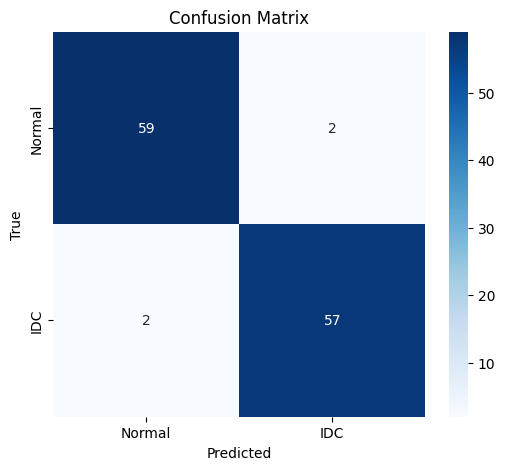


📈 Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97        61
         IDC       0.97      0.97      0.97        59

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [4]:
# === Stage 1: Configuration and Setup ===
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from timm import create_model

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
DATA_DIR = "/content/drive/MyDrive/CAPSTONE/Dataset_patches_small"
SAVE_DIR = "/content/drive/MyDrive/CAPSTONE"
METRIC_DIR = os.path.join(SAVE_DIR, "metrics")
MODEL_PATH = os.path.join(SAVE_DIR, "best_model.pth")

# Create directories if not exist
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(METRIC_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 8
IMG_SIZE = 224
NUM_CLASSES = 2
EPOCHS = 30
LR = 0.0005

# Labels
CLASS_NAMES = ['Normal', 'IDC']

# === Stage 2: Data Preparation ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# === Stage 3: Model Setup ===
model = create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# === Stage 4: Training ===
def train(model):
    best_acc = 0.0
    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            torch.save(model.state_dict(), MODEL_PATH)
            best_acc = val_acc
            print("✅ Best model saved.")

    # Plot accuracy
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.grid()
    plt.savefig(os.path.join(METRIC_DIR, "accuracy_curve.png"))
    plt.show()

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.grid()
    plt.savefig(os.path.join(METRIC_DIR, "loss_curve.png"))
    plt.show()

# === Stage 4.5: Skip Training if model exists ===
if os.path.exists(MODEL_PATH):
    print("✅ Found existing model. Skipping training...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
else:
    print("🚀 No model found. Starting training...")
    train(model)

# === Stage 5: Evaluation ===
model.eval()
all_preds, all_labels = [], []
actual_vs_predicted = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for true, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            actual_vs_predicted.append((CLASS_NAMES[true], CLASS_NAMES[pred]))

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n📊 Test Accuracy: {acc:.4f}")

# Actual vs Predicted
print("\n📋 Actual vs Predicted:")
for actual, predicted in actual_vs_predicted[:30]:  # Limit to 30 for brevity
    print(f"Actual: {actual}, Predicted: {predicted}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(METRIC_DIR, "confusion_matrix.png"))
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
print("\n📈 Classification Report:\n", report)
with open(os.path.join(METRIC_DIR, "classification_report.txt"), "w") as f:
    f.write(report)
